<a href="https://colab.research.google.com/github/gcbiotec/Transfer_Learning/blob/main/Transfer_Learning_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning**

We're going to use the Transfer Learning process, which consist of using a neural network well known (VGG16) as a fixed feature extractor to train a smaller custom classifier on our own images. 

In [36]:
# %matplotlib is a magic function in IPython. We use it to render the figure in a notebook (instead of displaying a dump of the figure object).
%matplotlib inline

In [37]:
# The module "os" provides a portable way of using operating system dependent functionality
# We can use the Theano library with GPU, and if so, we need to run this command:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

Theano is a Python library that allows you to define, optimize, and efficiently evaluate mathematical expressions involving multi-dimensional arrays. It is built on top of NumPy.

In [38]:
# Now we need to import some basic libraries, togheter with keras
import random
import numpy as np
import keras

In [39]:
# Here the libraries for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

Keras and TensorFlow libraries configuring..  

In [40]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import seaborn as sns
import zipfile
import cv2
import pandas as pd
import tensorflow as tf
from google.colab.patches import cv2_imshow
tf.__version__

'2.9.2'

**Getting our dataset**  
We're using the Cat vs Dog sataset from Kaggle, which will be stored at my Drive folder, after I download it.


In [43]:
# By running the code below, we can connect to our Drive and use the dataset from there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Let's extract the .zip
# It will generate a folder with 2 another folders: 'test_set' and 'training_set'
path = '/content/drive/MyDrive/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

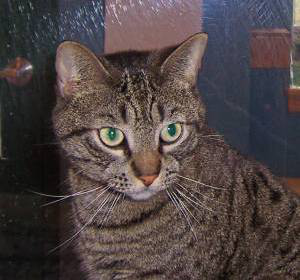

In [45]:
# Let's visualize an image of cat treining set:
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.1.jpg')

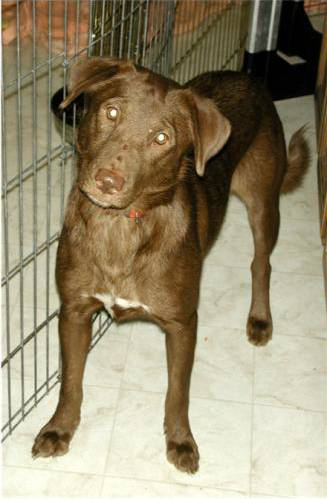

In [46]:
# Let's visualize an image of cat treining set:
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.1.jpg')

Now let's start generating some pictures using this tool and save them to a temporary directory, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable:

In [51]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [53]:
dataset_training = datagen.flow_from_directory('/content/cat_dog/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


In [54]:
# We can some other alterations to the images:
datagen = ImageDataGenerator(
        rotation_range=7, # Rotation
        zoom_range=0.2, # 20% zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

In [55]:
# This is used to generate normal images, that is, without modifications
datanorm = ImageDataGenerator()

In [58]:
# Let's apply other modifications to the training set:
altered_train = datagen.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), # convert all images to a standart
                  color_mode="rgb", # colored images
                  batch_size=1, # number of images extracted per batch
                  class_mode="binary", # classes are binary {cat / dog}
                  seed=2020 # to obtain reproductile results
                  )

Found 4000 images belonging to 2 classes.


In [59]:
normal_train = datanorm.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), 
                  color_mode="rgb", 
                  batch_size=1, 
                  class_mode="binary", 
                  seed=2020 
                  )

Found 4000 images belonging to 2 classes.


Now we can display the images in a grid to check if the process of transformation was sucefull

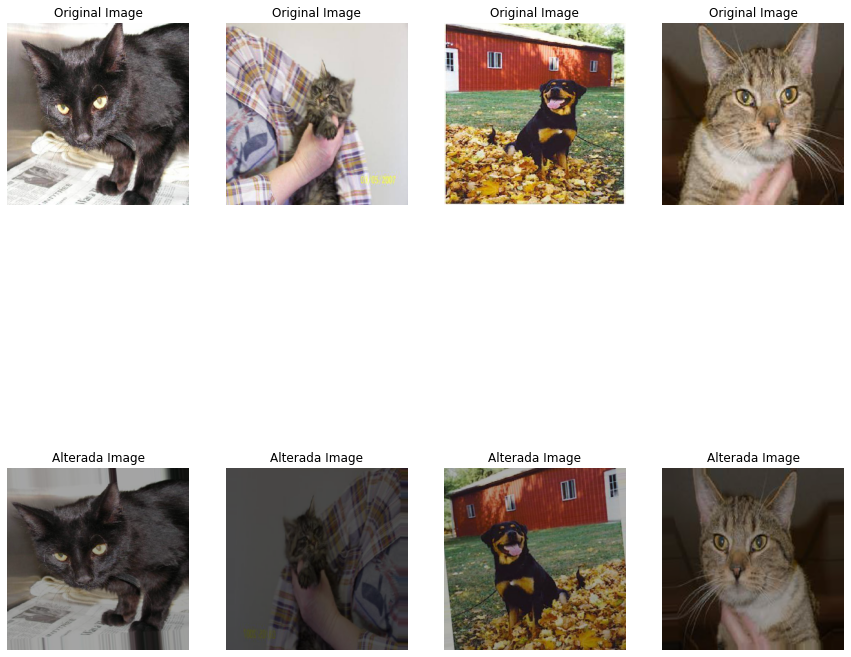

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))
for i in range(4):

  # convertendo the image in integer:
  image = next(altered_train)[0].astype('uint8')
  image2 = next(normal_train)[0].astype('uint8')

  # format alteration (1, 200, 200, 3) to (200, 200, 3) for image plotting:
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotting the images:
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Original Image')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Alterada Image')
  ax[1,i].axis('off')

## Now we have to do same thing to the test dataset:

In [62]:
test_gen = ImageDataGenerator(rescale=1./255)

In [63]:
dataset_ForTest = test_gen.flow_from_directory('/content/cat_dog/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


### It's time for using a pre-trained model!

In [ ]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))
base_model.summary()

In [68]:
# let's see how many layers there are:
len(base_model.layers)

154

In [69]:
# We can freeze the weigths..
for layer in base_model.layers:
  layer.trainable = False

In [70]:
# Checking the last layer of the model
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [72]:
# There are 1280 conections, but since we have two output classe, let us divide by 2
head_model = base_model.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [73]:
# Now we'll connect the base model with the other layers of our trained model, for our dataset
network = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
network.summary()

In [75]:
len(network.layers)

160

In [76]:
# Let's compile the model!
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [79]:
# And finally train our new model:
historic_training = network.fit(dataset_training, epochs=10)

Epoch 1/10
32/32 [==============================] - 67s 2s/step - loss: 0.6484 - accuracy: 0.6192
Epoch 2/10
32/32 [==============================] - 79s 2s/step - loss: 0.6421 - accuracy: 0.6250
Epoch 3/10
32/32 [==============================] - 65s 2s/step - loss: 0.6438 - accuracy: 0.6265
Epoch 4/10
32/32 [==============================] - 68s 2s/step - loss: 0.6419 - accuracy: 0.6298
Epoch 5/10
32/32 [==============================] - 68s 2s/step - loss: 0.6375 - accuracy: 0.6305
Epoch 6/10
32/32 [==============================] - 66s 2s/step - loss: 0.6396 - accuracy: 0.6338
Epoch 7/10
32/32 [==============================] - 68s 2s/step - loss: 0.6351 - accuracy: 0.6292
Epoch 8/10
32/32 [==============================] - 65s 2s/step - loss: 0.6348 - accuracy: 0.6375
Epoch 9/10
32/32 [==============================] - 67s 2s/step - loss: 0.6318 - accuracy: 0.6488
Epoch 10/10
32/32 [==============================] - 65s 2s/step - loss: 0.6252 - accuracy: 0.6447


In [80]:
# Let's evaluate the model..
network.evaluate(dataset_training)

32/32 [==============================] - 65s 2s/step - loss: 0.6176 - accuracy: 0.6465


[0.6175839900970459, 0.6464999914169312]

In [81]:
# Finally we are making our predictions
model_predictions = network.predict(dataset_ForTest)
model_predictions

1000/1000 [==============================] - 37s 36ms/step


array([[9.99455750e-01, 5.44286915e-04],
       [9.86254573e-01, 1.37454225e-02],
       [9.99687076e-01, 3.12943856e-04],
       ...,
       [9.99319911e-01, 6.80134865e-04],
       [9.85096991e-01, 1.49029894e-02],
       [9.84350562e-01, 1.56493839e-02]], dtype=float32)

In [82]:
# Now let's apply the model for predicting on the part of data for testing:
# We are predicting to which class each sample will be assigned
model_predictions = np.argmax(model_predictions, axis = 1)
model_predictions[:10] # first 10 samples

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [83]:
# Let's check what were the first 10 occurence is the test data
dataset_training.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [85]:
# But what numbers corresponds to which class?
dataset_training.class_indices

{'cat': 0, 'dog': 1}

## It's a good practice to check some parameters about our predictions:

In [84]:
# We can use a function of the Scikit learn to check accuracy:
from sklearn.metrics import accuracy_score
accuracy_score(dataset_ForTest.classes, model_predictions)

0.5

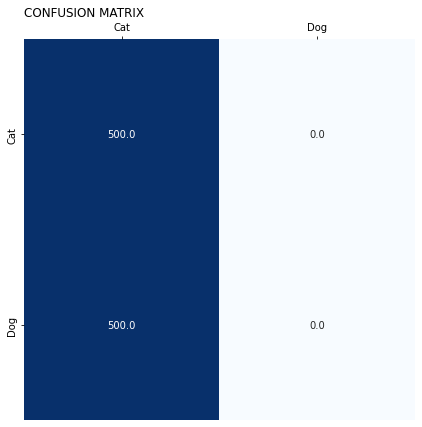

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_ForTest.classes, model_predictions)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Confusion Matrix'.upper()
plt.title(title, loc='left')
plt.show()

In [88]:
from sklearn.metrics import classification_report
print(classification_report(dataset_ForTest.classes, model_predictions))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       500
           1       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
# Loading an image:
image = cv2.imread('/content/cat_dog/test_set/dog/dog.3506.jpg')

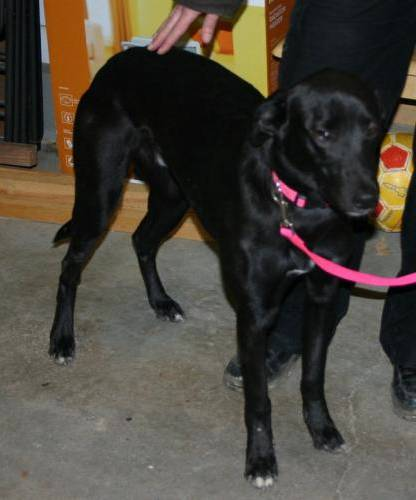

In [90]:
cv2_imshow(image)

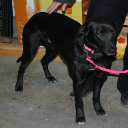

In [93]:
# Let's resize:
image = cv2.resize(image, (128, 128))
cv2_imshow(image)

In [ ]:
# And normalize it by dividing for 255
image = image/255
image

In [96]:
# Checking the size.. we'll see it's not on the right size for the model
image.shape

(128, 128, 3)

In [97]:
# Then, let's reshape it
image = image.reshape(1,128,128,3)

In [99]:
# Predicting on this image
new_predict = network(image)
new_predict

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9831624 , 0.01683762]], dtype=float32)>

In [100]:
new_predict = np.argmax(new_predict)
new_predict

0

Links:   
https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline  
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
https://www.kaggle.com/code/ktbrand/cats-vs-dogs-basic-cnn-tutorial


